# Taxi demand prediction using linear regression

### Case study: Wall street, NYC 

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("./dataset/pickups+weather_wallstreet.csv")
df.shape

(65712, 15)

In [3]:
df.head()

,datetime,pickups,date,min_temp,max_temp,wind_speed,wind_gust,visibility,pressure,precipitation,snow_depth,fog,rain_drizzle,snow_ice,thunder
0,2009-01-01 00,47,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
1,2009-01-01 01,74,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
2,2009-01-01 02,79,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
3,2009-01-01 03,57,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
4,2009-01-01 04,46,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0


In [4]:
df.dtypes

datetime          object
pickups            int64
date              object
min_temp         float64
max_temp         float64
wind_speed       float64
wind_gust        float64
visibility       float64
pressure         float64
precipitation    float64
snow_depth       float64
fog                int64
rain_drizzle       int64
snow_ice           int64
thunder            int64
dtype: object

In [5]:
## Convert datetime column into datetime object
df["datetime"]=pd.to_datetime(df["datetime"],format="%Y-%m-%d")

### Histogram

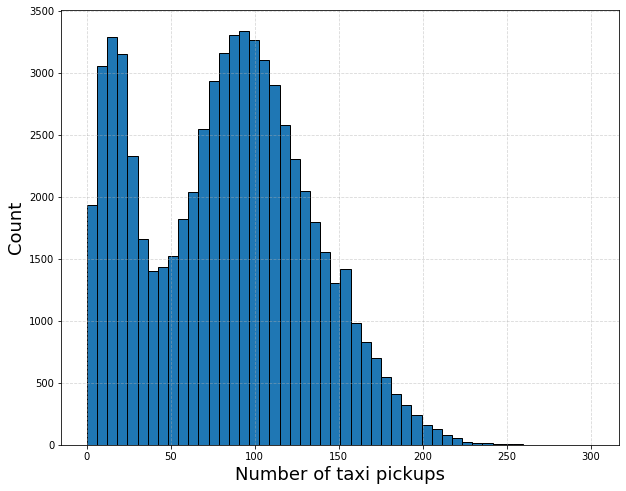

In [6]:
plt.figure(figsize=(10,8))
plt.hist(df.pickups,edgecolor="black",bins=50)
plt.ylabel("Count",fontsize=18)
plt.xlabel("Number of taxi pickups",fontsize=18)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=.5,linestyle='--')
plt.savefig("dist.png",dpi=300);

### Scatter plot

C:\Users\Meghdad\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


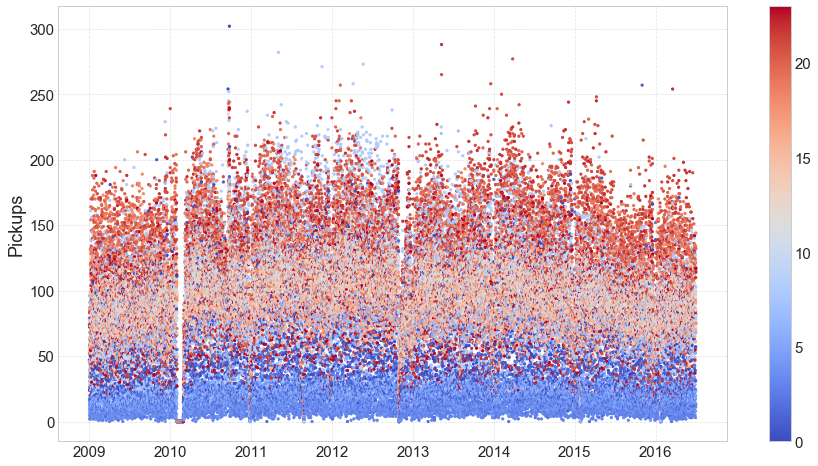

In [7]:
df["hourPastMid"]=df.datetime.dt.hour

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(15,8))
plt.scatter(df.datetime,df.pickups,s=5,c=df["hourPastMid"],cmap='coolwarm')
plt.ylabel("Pickups",fontsize=18)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=.5,linestyle='--')
plt.colorbar()
plt.savefig("ts.png",dpi=300);

### Weekdays vs. Weekends

In [8]:
weekdays=[0,1,2,3,4]
weekends=[5,6]

In [9]:
df_TS=df[["datetime","pickups"]]
weekdays=df_TS[df_TS.datetime.dt.weekday<5]
weekends=df_TS[df_TS.datetime.dt.weekday>4]
avg_weekdays=[]
avg_weekends=[]

for hour in range(24):
    avg_weekdays.append(weekdays[weekdays.datetime.dt.hour==hour].pickups.mean())
    avg_weekends.append(weekends[weekends.datetime.dt.hour==hour].pickups.mean())
    

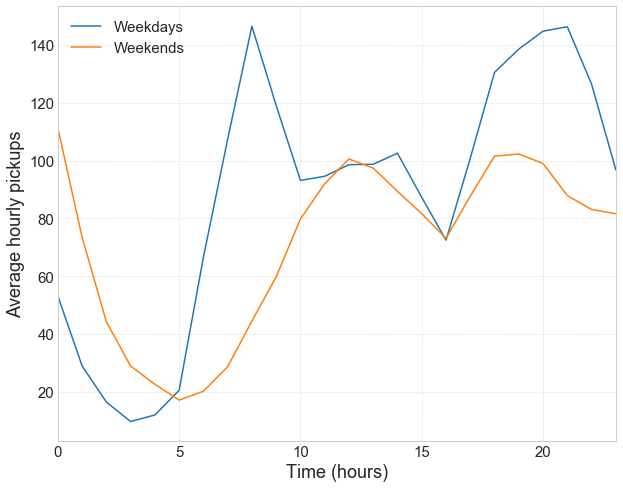

In [10]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10,8))
plt.plot(avg_weekdays,label="Weekdays")
plt.plot(avg_weekends,label="Weekends")
plt.legend()
plt.xlabel("Time (hours)",fontsize=18)
plt.ylabel("Average hourly pickups",fontsize=18)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=.5,linestyle='--')
plt.legend(fontsize=15)
plt.xlim([0,23])
plt.savefig("week.png",dpi=300);

### Adding time of day and day of week as dummy variables 

In [11]:
df.head()
## add column with day of week(dow) and time of day(tod)
df["dow"]=df.datetime.dt.weekday
df["tod"]=df.datetime.dt.hour

In [12]:
dummy_week=pd.get_dummies(df["dow"])
dummy_hour=pd.get_dummies(df["tod"])
week_colName = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dummy_week.set_axis(week_colName, axis=1, inplace=True)

In [13]:
new_df=pd.concat([df, dummy_week,dummy_hour],axis=1).set_index("datetime").drop(["date","tod","dow"],axis=1)
new_df.shape

(65712, 45)

## Modeling section 

In [14]:
# mean and standard deviation of pickups 
y_std=new_df.pickups.std()
y_mean=new_df.pickups.mean()

In [16]:
## Standardization
from sklearn import preprocessing
# Get column names first
names = new_df.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(new_df)
scaled_df = pd.DataFrame(scaled_df, columns=names)

In [ ]:
## Accuracy measures 
def compute_error(trues,predicted):
    corr=np.corrcoef(predicted,trues)[0,1]
    mae=np.mean(np.abs(predicted-trues))
    rae=np.sum(np.abs(predicted-trues))/np.sum(np.abs(trues-np.mean(trues)))
    rmse=np.sqrt(np.mean((predicted-trues)**2))
    r2=max(0,1-np.sum((trues-predicted)**2)/np.sum((trues-np.mean(trues))**2))
    return corr,mae,rae,rmse,r2

### Model 1: Regression model without the lagged variable 

In [ ]:
## with standardization
y=scaled_df.pickups
X=scaled_df.drop("pickups",axis=1)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [21]:
from sklearn import linear_model
reg= linear_model.LinearRegression()
reg.fit(X_train,y_train)
y_hat=reg.predict(X_test)

## convert standardized data into actual data
preds=y_hat*y_std+y_mean
y_true=y_test*y_std+y_mean

In [22]:
corr, MAE, RAE, RMSE, R2=compute_error(y_true,preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" %(corr, MAE,RMSE, R2))

CorrCoef: 0.771
MAE: 23.450
RMSE: 31.057
R2: 0.595


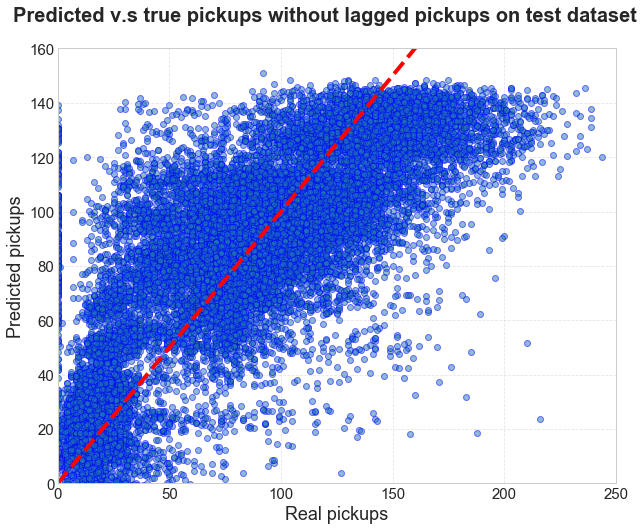

In [23]:
plt.figure(figsize=(10,8))
plt.scatter(y_true,preds,alpha=.5,edgecolors='b')
plt.xlabel("Real pickups",fontsize=18)
plt.ylabel("Predicted pickups",fontsize=18)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=.5,linestyle='--')
plt.plot(np.linspace(0,200,1000),np.linspace(0,200,1000),"r--",linewidth=4)
plt.xlim([0, 250])
plt.ylim([0, 160])
figure_title = "Predicted v.s true pickups without lagged pickups on test dataset"

plt.text(-20,170, figure_title,fontsize=20,weight='bold')
plt.savefig("PT_without.png",dpi=300);

### Model 2: Regression model with the lagged variable 

In [26]:
new_df["lag_pickups"]=new_df.pickups.shift()
new_df.dropna(inplace=True)

In [27]:
from sklearn import preprocessing
# Get column names first
names = new_df.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(new_df)
scaled_df = pd.DataFrame(scaled_df, columns=names)

In [30]:
## with standardization
y=scaled_df.pickups
X=scaled_df.drop("pickups",axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

reg= linear_model.LinearRegression()
reg.fit(X_train,y_train)
y_hat=reg.predict(X_test)

preds=y_hat*y_std+y_mean
y_true=y_test*y_std+y_mean

In [31]:
corr, MAE, RAE, RMSE, R2=compute_error(y_true,preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" %(corr, MAE,RMSE, R2))

CorrCoef: 0.919
MAE: 14.551
RMSE: 19.190
R2: 0.844


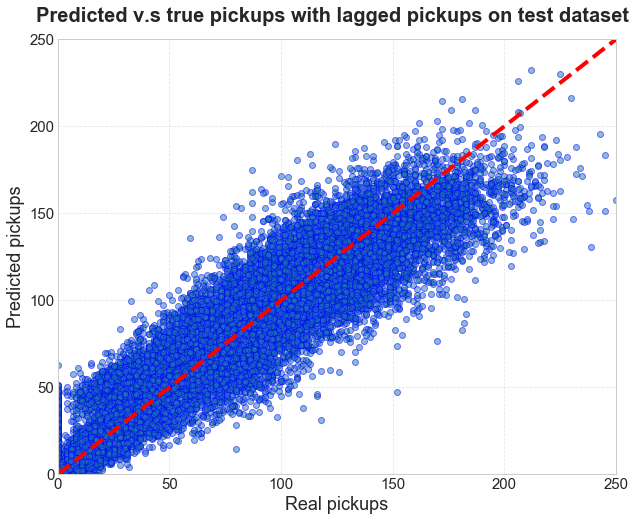

In [32]:
plt.figure(figsize=(10,8))
plt.scatter(y_true,preds,alpha=.5,edgecolors='b')
plt.xlabel("Real pickups",fontsize=18)
plt.ylabel("Predicted pickups",fontsize=18)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=.5,linestyle='--')
plt.plot(np.linspace(0,250,1000),np.linspace(0,250,1000),"r--",linewidth=4)
plt.xlim([0, 250])
plt.ylim([0, 250])
figure_title = "Predicted v.s true pickups with lagged pickups on test dataset"

plt.text(-10,260, figure_title,fontsize=20,weight='bold')
plt.savefig("PT_with.png",dpi=300);